<a href="https://colab.research.google.com/github/AlexBaunti/Prediction_AI/blob/main/RandomTreeMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Метод решающих деревьев**

# Инициализация библиотек

Подключение необходимых для работы библиотек.




In [47]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np # обращение сокращенно np
import pandas as pd # обращение сокращенно pd
import missingno as msno # обращение сокращенно msno
import seaborn as sns # обращение сокращенно sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt # обращение сокращенно plt
%matplotlib inline
from sklearn import linear_model, ensemble # алгоритмы sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error # меры качества

# Загрузка данных

Получение файлов с данными из GitHub репозитория. 

Получение файлов с данными по ссылке на репозиторий. Данные для обучения и теста передаются в соответствующие переменные. Для чтения Excel-таблиц используется команда "read_excel".  

In [2]:
%%capture
!wget https://raw.githubusercontent.com/AlexBaunti/Prediction_AI/main/COVID_Test_Data.xlsx
!wget https://raw.githubusercontent.com/AlexBaunti/Prediction_AI/main/COVID_Training_Data.xlsx
training_data = pd.read_excel('COVID_Training_Data.xlsx')
test_data = pd.read_excel('COVID_Test_Data.xlsx')

Проверка данных - первые 5 строк таблицы с тренировочными данными

In [3]:
training_data.head()

,Пробиотик,Возраст,Пол,Рост,Вес,ИМТ,ПлощадьТела,ПредраспССЗ,Курение,Алкоголь,...,МочКислот,Ддимеры,вчСРБ,ХЛНП,ИнАтероген,неХЛВП,ШкБорга,ТестEQ,ТШХдо,Class15
0,0,54,2,151,58,25.437481,1.559736,0,0,0,...,330,120,12.0,3.500000,4.875000,3.90,2,11,300,1
1,0,63,2,165,115,42.240588,2.295830,1,0,0,...,240,85,6.5,4.631818,4.500000,5.40,2,13,280,1
2,0,50,2,159,46,18.195483,1.425365,0,0,0,...,248,100,40.0,3.220909,6.306667,4.73,2,12,300,1
3,0,41,2,166,92,33.386558,2.059666,1,0,0,...,220,125,25.0,2.136364,2.676768,2.65,2,12,300,1
4,0,37,2,161,71,27.390919,1.781931,1,0,0,...,340,177,12.0,2.931818,3.700000,3.70,2,13,300,1


Считывание размерности таблицы с тренировочными данными

In [4]:
training_data.shape

(64, 84)

Полная таблица данных размерность 64 х 84 успешно передана.

# Разделение входных данных и выходной переменных

Передача частей данных в отдельные переменные

Необходимо спрогнозировать эффективность выздоровление пациента, поэтому выходная переменная - это Class15. Запишем название столбца таблицы, в котором содержится целевая функция, в переменную target_variable:

In [6]:
target_variable = 'Class15'

Теперь выделим в отдельную переменную training_target_variable весь столбец со значениями целевой переменной.

In [25]:
training_target_variable = training_data[target_variable]

В отдельную переменную training_samples запишем признаки - то есть всю обучающую таблицу, за исключением целевой переменной. Для этого вызовем у переменной training_data метод drop() и удалим столбец "Class15".

In [26]:
training_samples = training_data.drop(target_variable, axis=1)

Проверим, что столбец действительно удалён с помощью методов *head* и *shape*.

In [27]:
training_samples.head()

,Пробиотик,Возраст,Пол,Рост,Вес,ИМТ,ПлощадьТела,ПредраспССЗ,Курение,Алкоголь,...,МНОтн,МочКислот,Ддимеры,вчСРБ,ХЛНП,ИнАтероген,неХЛВП,ШкБорга,ТестEQ,ТШХдо
0,0,54,2,151,58,25.437481,1.559736,0,0,0,...,0.87,330,120,12.0,3.500000,4.875000,3.90,2,11,300
1,0,63,2,165,115,42.240588,2.295830,1,0,0,...,0.98,240,85,6.5,4.631818,4.500000,5.40,2,13,280
2,0,50,2,159,46,18.195483,1.425365,0,0,0,...,1.01,248,100,40.0,3.220909,6.306667,4.73,2,12,300
3,0,41,2,166,92,33.386558,2.059666,1,0,0,...,0.90,220,125,25.0,2.136364,2.676768,2.65,2,12,300
4,0,37,2,161,71,27.390919,1.781931,1,0,0,...,0.96,340,177,12.0,2.931818,3.700000,3.70,2,13,300


In [28]:
training_samples.shape

(64, 83)

# Анализ набора данных

Получение необходимой информации о данных.

Получим общую информацию о полном наборе данных

In [34]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 84 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Пробиотик       64 non-null     int64  
 1   Возраст         64 non-null     int64  
 2   Пол             64 non-null     int64  
 3   Рост            64 non-null     int64  
 4   Вес             64 non-null     int64  
 5   ИМТ             64 non-null     float64
 6   ПлощадьТела     64 non-null     float64
 7   ПредраспССЗ     64 non-null     int64  
 8   Курение         64 non-null     int64  
 9   Алкоголь        64 non-null     int64  
 10  Гиподинамия     64 non-null     int64  
 11  КТ              64 non-null     int64  
 12  ДеньПослеCovid  64 non-null     int64  
 13  СлабостьДо      64 non-null     int64  
 14  БольСердцаДо    64 non-null     int64  
 15  Седцебиение     64 non-null     int64  
 16  ПеребоиДо       64 non-null     int64  
 17  ОдышкаДо        64 non-null     int64

Анализируем результата выполнения команды:

* 64 экземпляра (строки)
* 84 признака (столбцы)

Имеется всего три различных типа данных (dtypes):

* int64 - целое число - 47 столбцов;
* float64 - дробное число - 35 столбцов;
* object - объект (текст) - 2 столбца;


Теперь проверим набор данных на сбалансированность. Для этого измерим количество значений классов в целевой переменной.

In [29]:
training_target_variable.value_counts()

1    37
0    27
Name: Class15, dtype: int64

На основе анализа можно сделать следующие выводы:

*   В некоторых признаках присутствуют значительные пропуски
*   В данных присутствует небольшое количество числовых выбросов
*   Набор данных имеет небольшой дисбаланс (IR = 1.37)




In [ ]:
training_samples = training_samples.drop('вчСРБ', axis=1)

# Обработка пропусков в данных

По полученной информации о данных следует, что в них имеются пропуски. Такой набор данных не может быть корректно обработан, необходимо избавиться от пропусков.


Получим опсательную статистику о наборе

In [49]:
training_samples.describe (include = [np.number])

,Пробиотик,Возраст,Пол,Рост,Вес,ИМТ,ПлощадьТела,ПредраспССЗ,Курение,Алкоголь,...,МНОтн,МочКислот,Ддимеры,вчСРБ,ХЛНП,ИнАтероген,неХЛВП,ШкБорга,ТестEQ,ТШХдо
count,64.000000,64.000000,64.000000,64.00000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,...,64.000000,64.000000,64.000000,15.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.00000
mean,0.484375,56.921875,1.718750,167.03125,80.937500,29.035638,1.927858,0.578125,0.046875,0.062500,...,1.079531,367.218750,169.328125,17.046667,3.174830,2.546198,3.634063,2.500000,12.015625,348.71875
std,0.503706,9.292948,0.453163,7.77658,17.141683,6.057935,0.221854,0.497763,0.213042,0.243975,...,0.131166,106.910208,315.460362,12.034644,0.967208,1.195598,0.926543,1.007905,2.081606,57.33900
min,0.000000,37.000000,1.000000,151.00000,46.000000,18.195483,1.425365,0.000000,0.000000,0.000000,...,0.870000,160.000000,0.000000,2.000000,1.181818,0.846561,1.300000,1.000000,8.000000,220.00000
25%,0.000000,49.750000,1.000000,160.75000,72.500000,24.389150,1.778233,0.000000,0.000000,0.000000,...,1.000000,284.750000,0.000000,11.500000,2.495682,1.786594,3.027500,2.000000,10.750000,300.00000
50%,0.000000,59.000000,2.000000,167.00000,80.000000,29.242109,1.952739,1.000000,0.000000,0.000000,...,1.065000,364.500000,106.500000,12.000000,3.154091,2.285092,3.675000,2.000000,12.000000,350.00000
75%,1.000000,63.250000,2.000000,172.00000,91.250000,32.095126,2.087045,1.000000,0.000000,0.000000,...,1.150000,438.500000,217.250000,22.500000,3.766364,2.959943,4.250000,3.000000,13.000000,400.00000
max,1.000000,72.000000,2.000000,182.00000,131.000000,44.921875,2.516280,1.000000,1.000000,1.000000,...,1.590000,637.000000,2366.000000,45.000000,5.900000,6.306667,5.760000,6.000000,16.000000,460.00000


Столбчатая диаграмма из библиотеки missingno позволяет увидеть разницу в количестве непустых экземпляров разных признаков. Слева указаны названия признаков, справа - количество заполненных значений в признаке, сверху - доля заполненных значений.

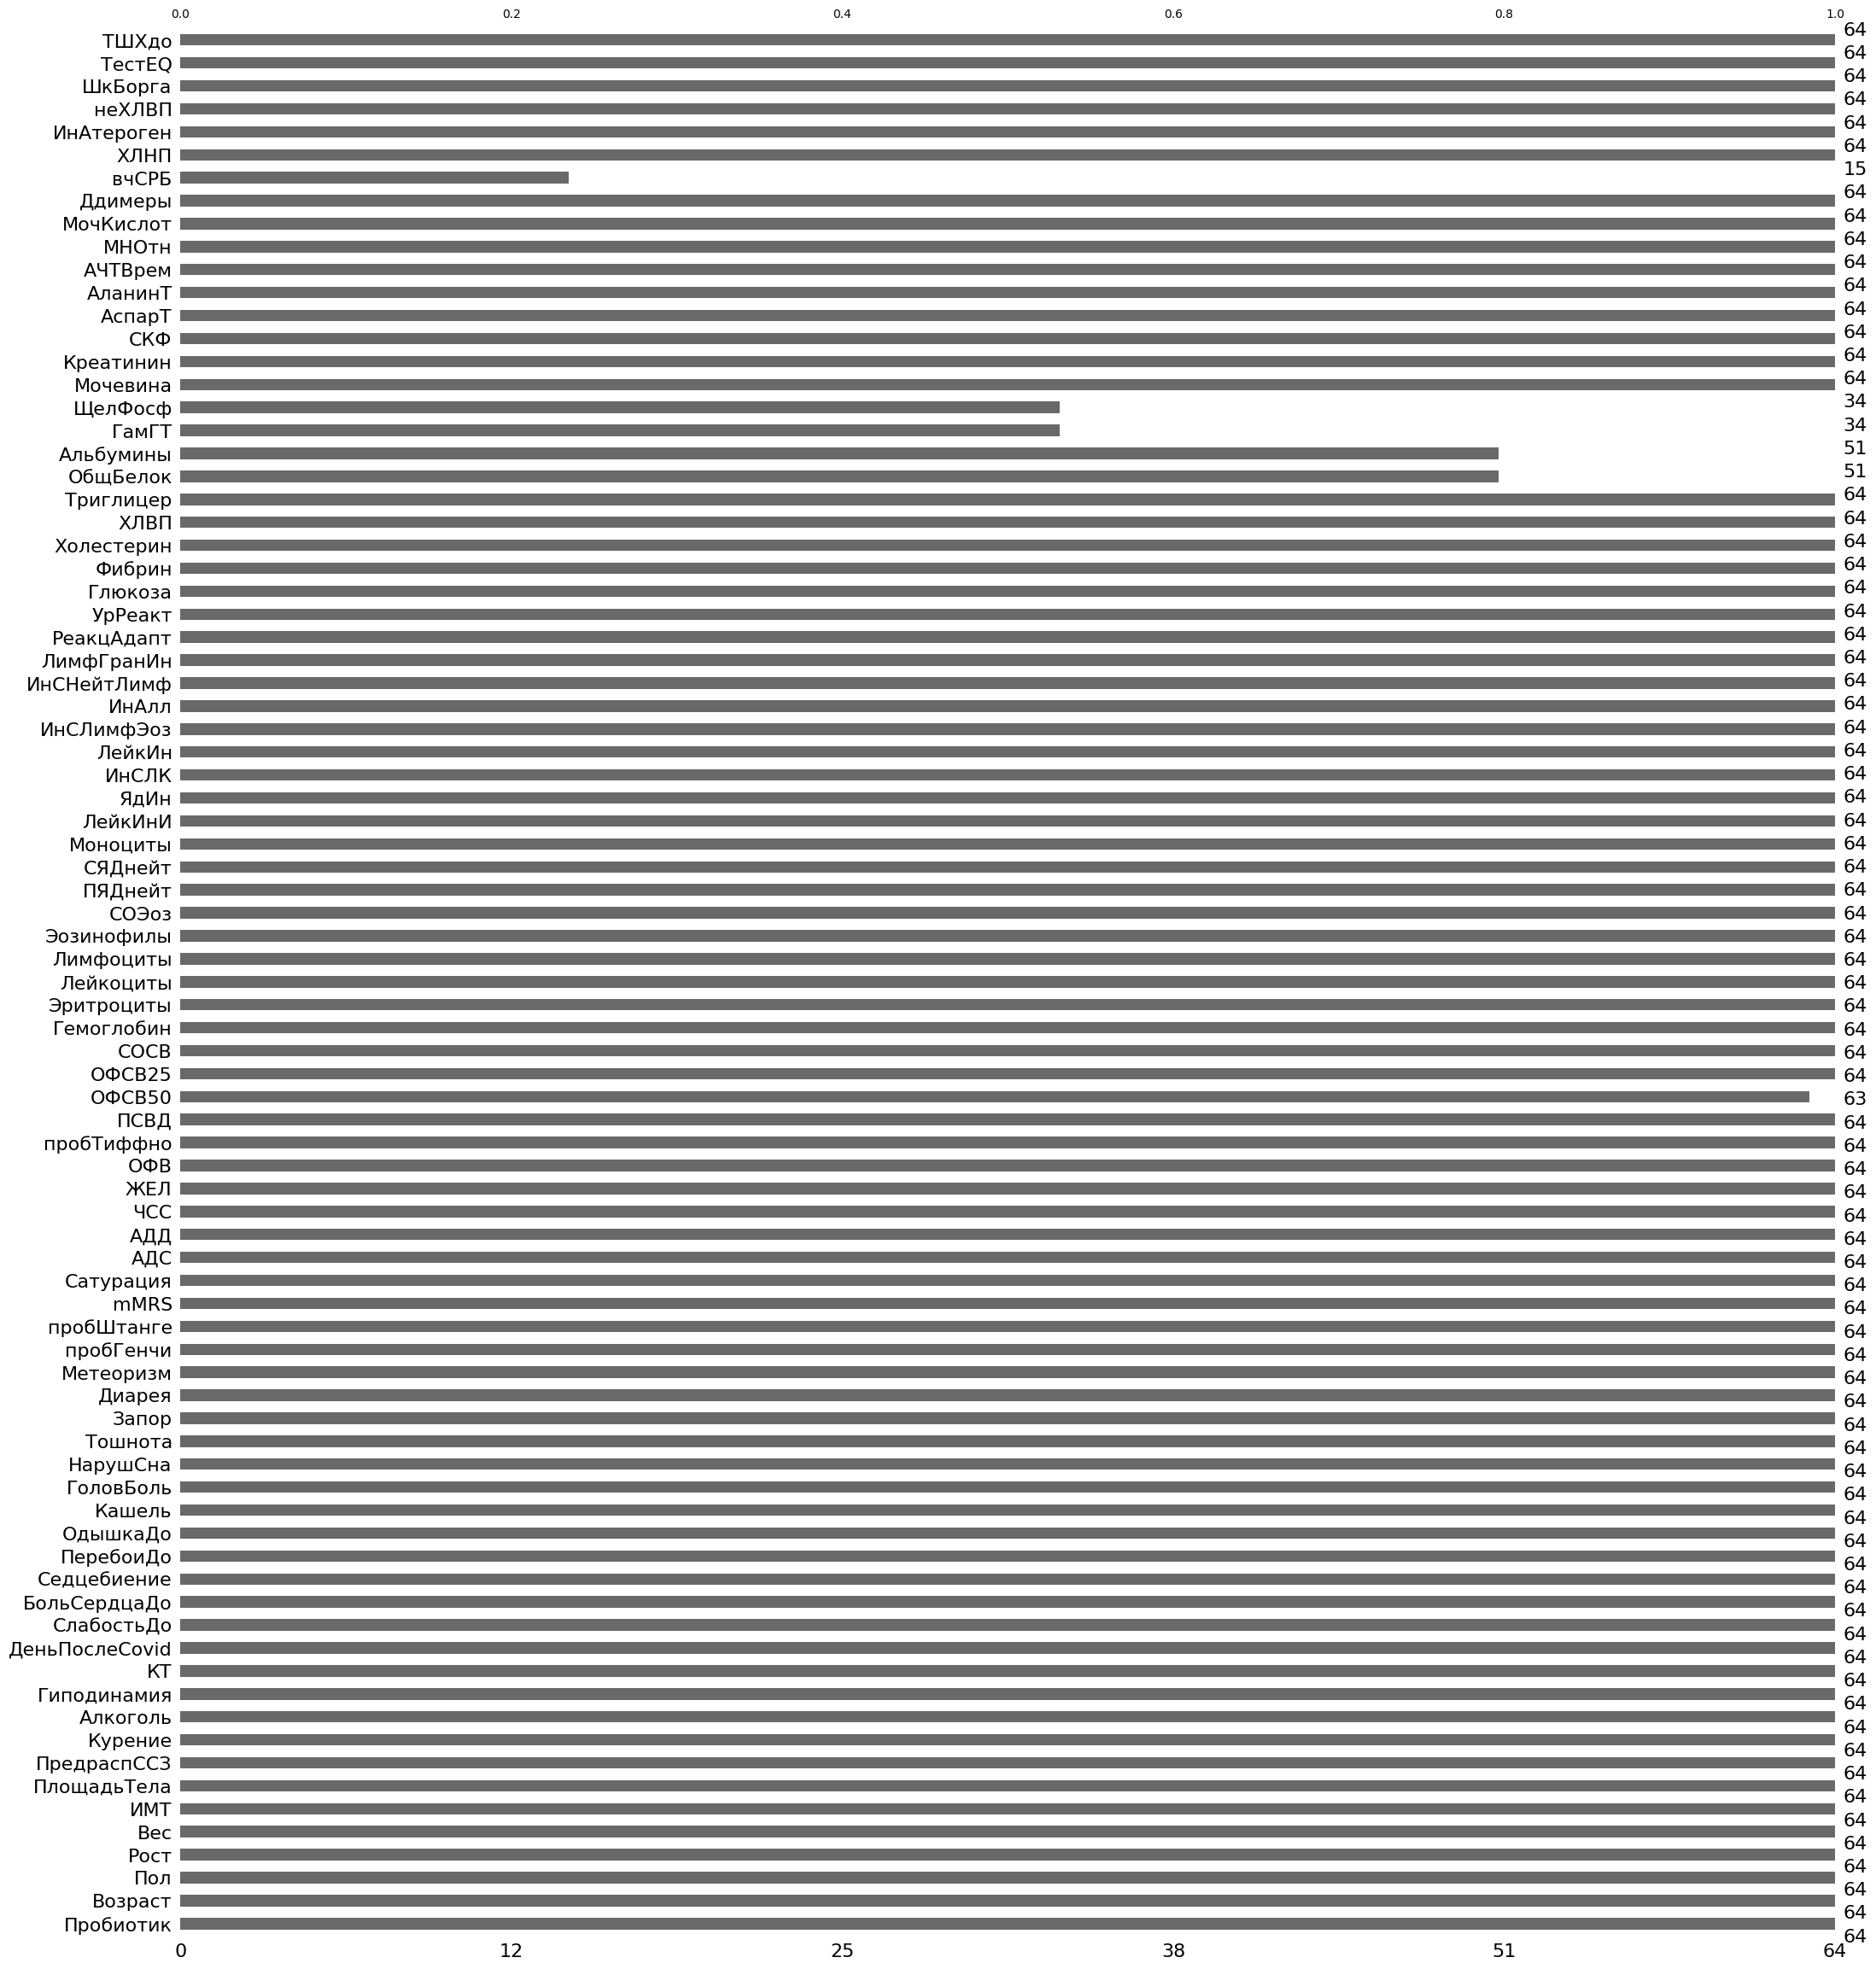

In [32]:
msno.bar(training_samples);

Матрица пропусков, вызываемая функцией matrix, показывает распределение пропусков по экземплярам.

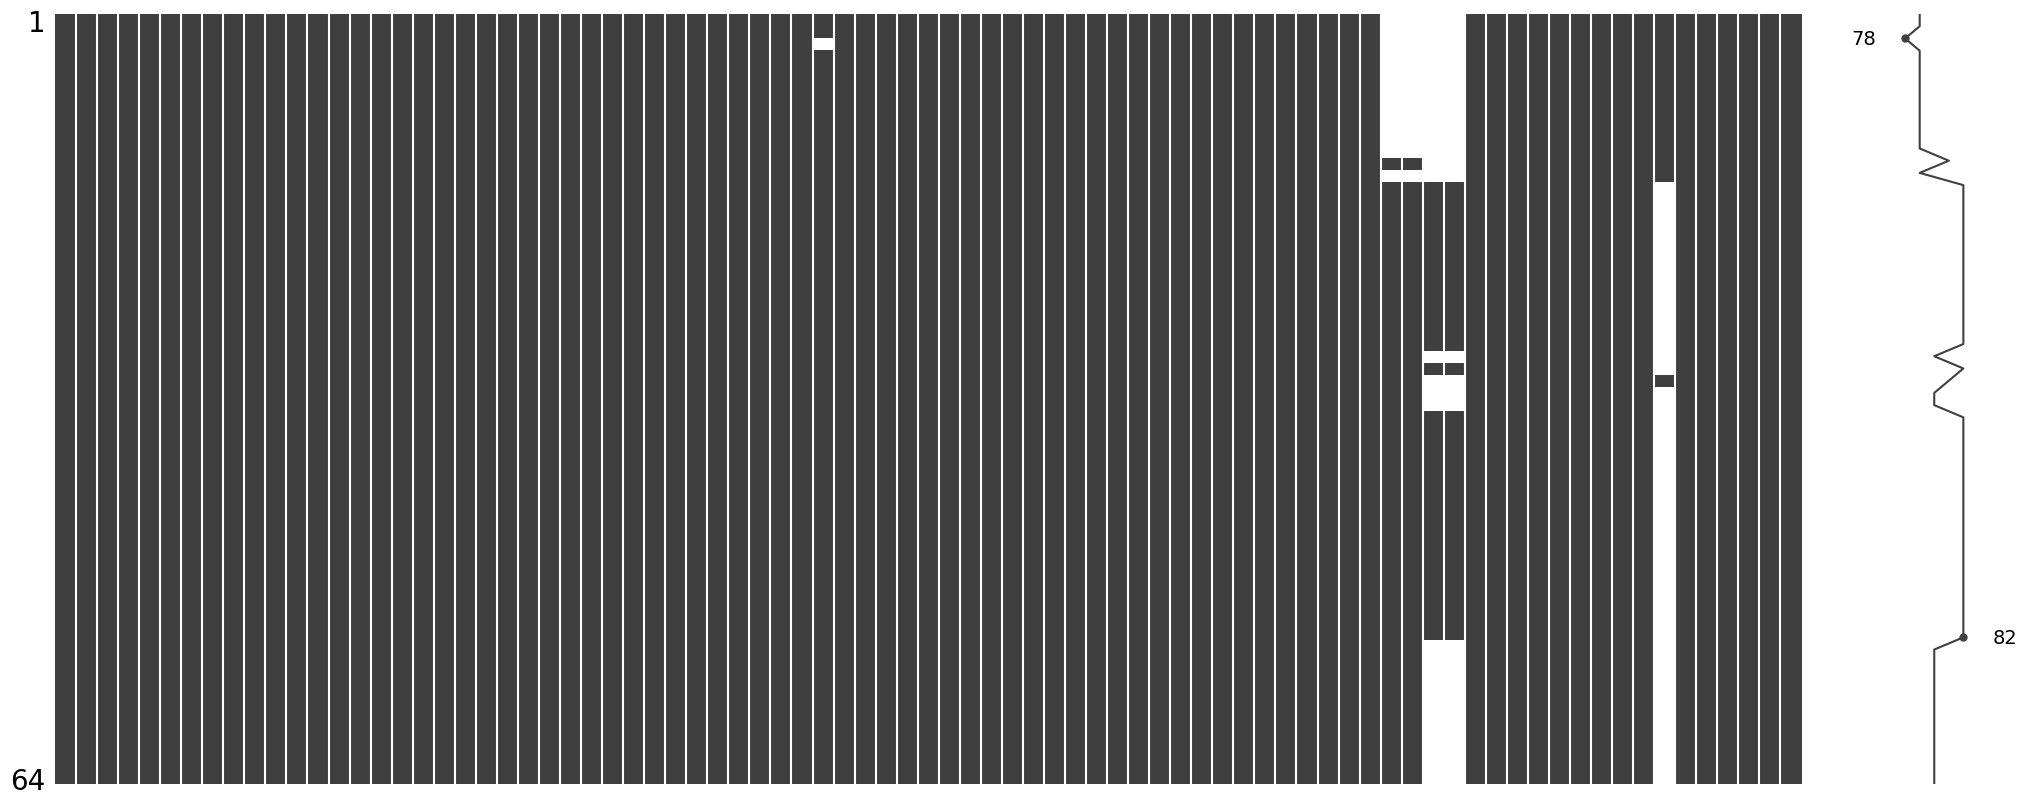

In [33]:
msno.matrix(training_samples);

Из анализа пропусков следует, что 6 признаков заполнены не полностью


*   вчСРБ (15 из 64)
*   ЩелФосф (34 из 64)
*   ГамГТ (34 из 64)
*   Альбумины (51 из 64)
*   ОбщБелок (51 из 64)
*   ОФСВ50 (63 из 64)

Так как признак "вчСРБ" заполнен лишь на 23,4% и содержит непригодные для обучения данные, его можно удалить.



In [ ]:
training_samples = training_samples.drop('вчСРБ', axis=1)

# Инициализация решающего алгоритма

Лес решающих деревьев - ансамбль из множества решающих деревьев. Решающее дерево - это алгоритм, иерархически раскладывающий данные на множество бинарных условий. 

Для создания модели случайного леса вызываем модуль ensemble, затем через точку указываем название алгоритма RandomForestRegressor.

In [ ]:
random_forest_model = ensemble.RandomForestRegressor()
random_forest_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Вызываем метод fit() у модели и передаем ему на вход два аргумента: таблицу входных признаков и столбец значений целевой переменной - (training_samples, training_target_variable)

In [ ]:
random_forest_model.fit(training_samples, training_target_variable)

ValueError: ignored